<a href="https://colab.research.google.com/github/marta-0/medical_mnist/blob/main/Medical-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical MNIST

In [1]:
import os
import pathlib
import random
import gc
import zipfile

from PIL import Image
import albumentations as A

import numpy as np
import math
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing import image

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## Download the files

In [2]:
!git clone https://github.com/apolanco3225/Medical-MNIST-Classification

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 47.48 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking out files: 100% (58959/58959), done.


## Check the classes and prepare the lists of files and labels

In [3]:
PATH = '/content/Medical-MNIST-Classification/resized'

p = pathlib.Path(PATH)

labels = [x.parts[-1] for x in p.iterdir()]
num_classes = len(labels)

labels.sort()
labels

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [4]:
files_paths = []
files_labels = []

for root, dirs, files in os.walk(PATH):
  p = pathlib.Path(root)

  for file in files:
    files_paths.append(root + '/' + file)
    files_labels.append(p.parts[-1])

In [5]:
len(files_labels), len(files_paths)

(58954, 58954)

In [6]:
labels_cnt = []

for label in labels:
  print(label, files_labels.count(label))
  labels_cnt.append(files_labels.count(label))

AbdomenCT 10000
BreastMRI 8954
CXR 10000
ChestCT 10000
Hand 10000
HeadCT 10000


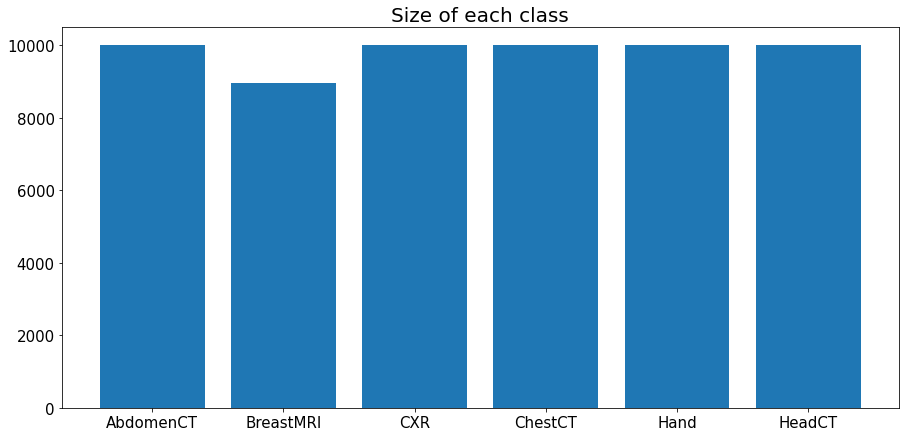

In [7]:
plt.figure(figsize=(15,7))
plt.bar(labels, labels_cnt)
plt.title('Size of each class', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

BreastMRI has less instances than the other classes.

## Prepare X and y

Images have been preprocessed already while collecting from databases. Each image is 64 x 64 px.

In [8]:
def prepare_X_y(files_paths, width=64, height=64):
  X = []

  for path in files_paths:
    img = Image.open(path)
    img.load()

    if (width or height) != 64:
      img = img.resize((width,height))

    img_X = np.asarray(img, dtype=np.int16)
    X.append(img_X)

  X = np.asarray(X)
  y = np.asarray(files_labels)

  return X, y

In [9]:
X, y = prepare_X_y(files_paths)

In [10]:
X.dtype

dtype('int16')

In [11]:
X.shape, y.shape

((58954, 64, 64), (58954,))

In [12]:
size = X.shape[-1]
size

64

## Visualisations

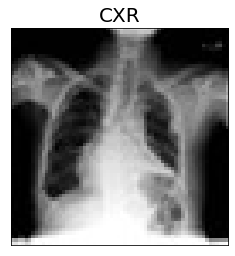

In [13]:
plt.imshow(X[10], cmap='gray')
plt.title(y[10], fontsize=20)
plt.xticks([])
plt.yticks([]);

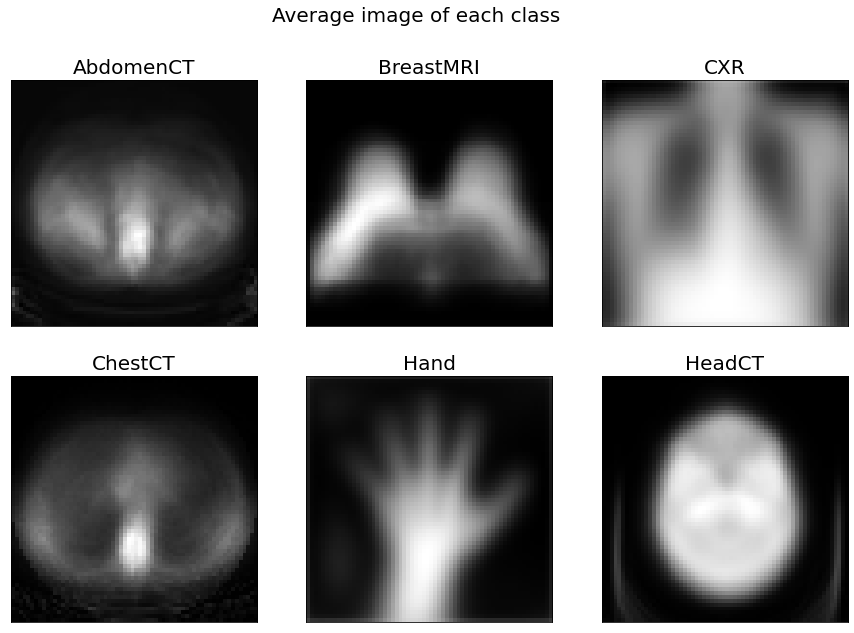

In [14]:
plt.figure(figsize=(15,10))
plt.suptitle('Average image of each class', fontsize=20)

i = 0
for label in labels:
  X_sum = np.sum(X[y ==label], axis=0)
  X_avg = X_sum / files_labels.count(label)
  
  plt.subplot(2,3,i+1)
  plt.imshow(X_avg, cmap='gray')
  plt.title(label, fontsize=20)
  plt.xticks([])
  plt.yticks([])
  i = i + 1

Several examples of each class:

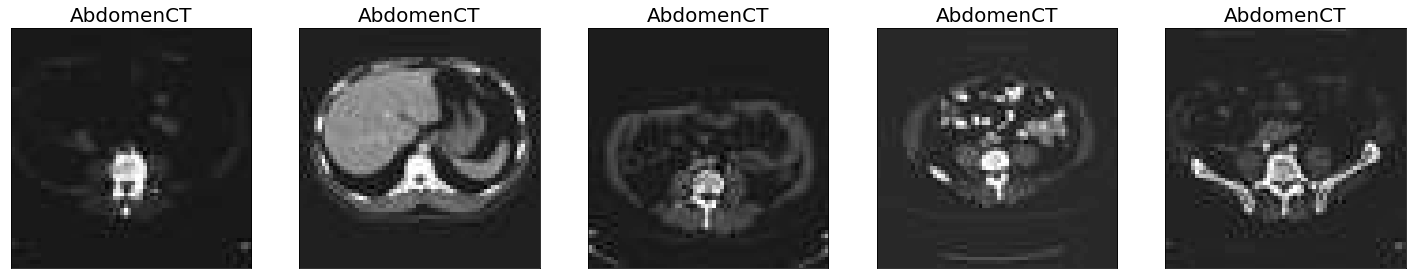

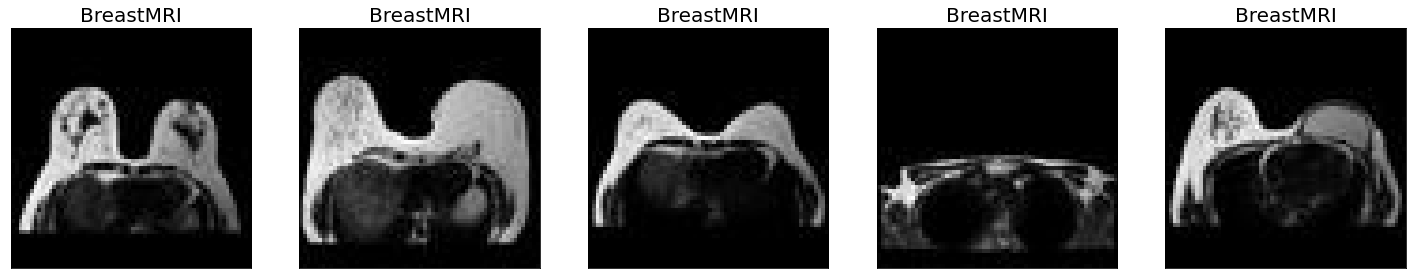

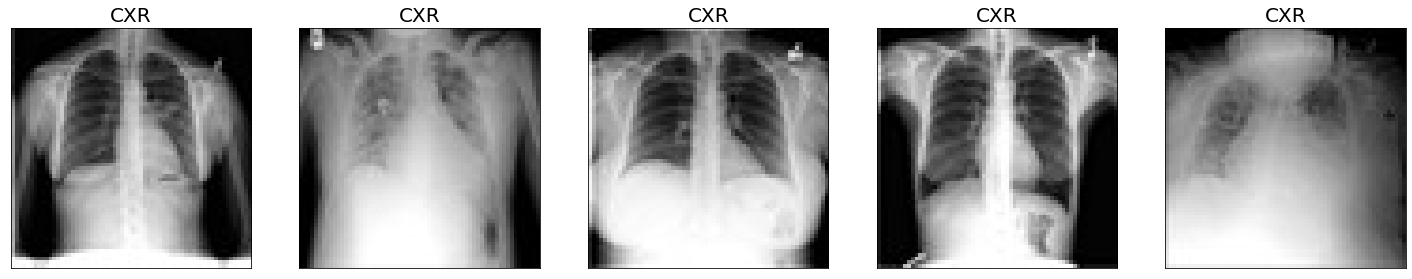

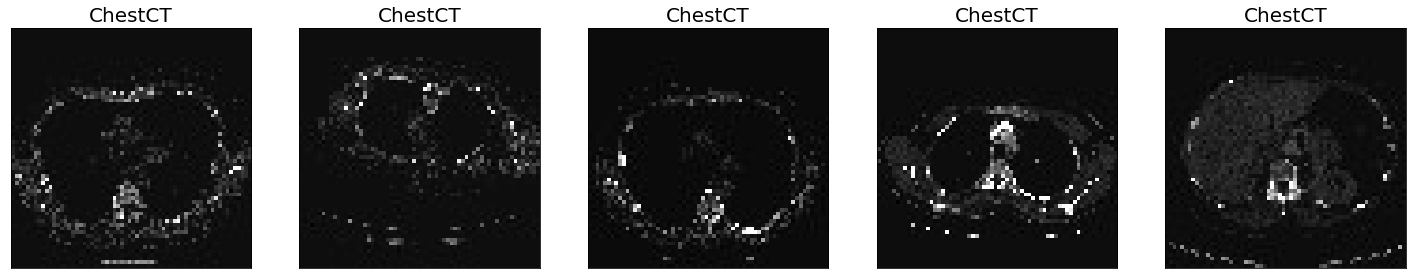

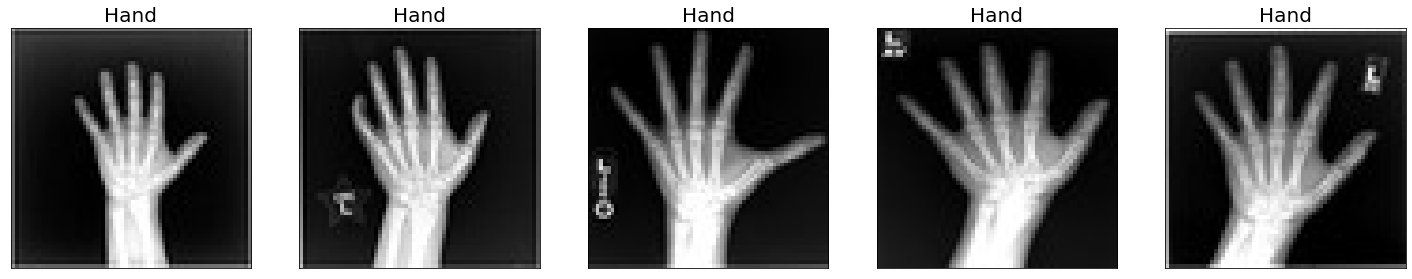

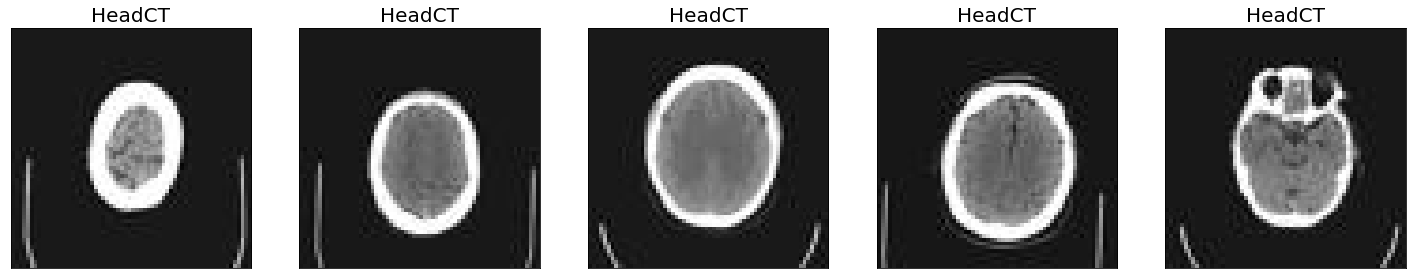

In [15]:
for label in labels:
    images = X[y == label] 
    
    plt.figure(figsize=(25,35))
    for i in range(5):
        plt.subplot(6, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(label, fontsize=20)
        plt.xticks([])
        plt.yticks([])

Examples of unusual images from each class:

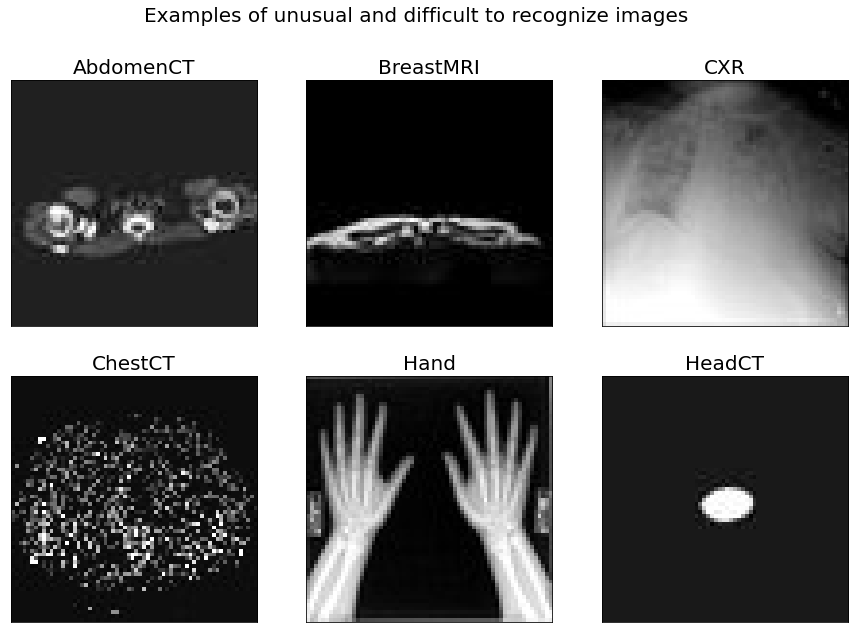

In [16]:
plt.figure(figsize=(15,10))
plt.suptitle('Examples of unusual and difficult to recognize images', fontsize=20)

def plot_unusual(i, path, title):
  plt.subplot(2,3,i)
  img = Image.open(path)
  plt.imshow(img, cmap='gray')
  plt.title(title, fontsize=20)
  plt.xticks([])
  plt.yticks([])

plot_unusual(1, '/content/Medical-MNIST-Classification/resized/AbdomenCT/005658.jpeg', 'AbdomenCT')
plot_unusual(2, '/content/Medical-MNIST-Classification/resized/BreastMRI/001248.jpeg', 'BreastMRI')
plot_unusual(3, '/content/Medical-MNIST-Classification/resized/CXR/009068.jpeg', 'CXR')
plot_unusual(4, '/content/Medical-MNIST-Classification/resized/ChestCT/006695.jpeg', 'ChestCT')
plot_unusual(5, '/content/Medical-MNIST-Classification/resized/Hand/006398.jpeg', 'Hand')
plot_unusual(6, '/content/Medical-MNIST-Classification/resized/HeadCT/000028.jpeg', 'HeadCT')

## Train test split

With *stratify*:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [18]:
labels_cnt_train = []
labels_cnt_test = []

for label in labels:
  labels_cnt_train.append(np.count_nonzero(y_train == label))
  labels_cnt_test.append(np.count_nonzero(y_test == label))

In [19]:
labels_cnt_train, labels_cnt_test

([7000, 6267, 7000, 7000, 7000, 7000], [3000, 2687, 3000, 3000, 3000, 3000])

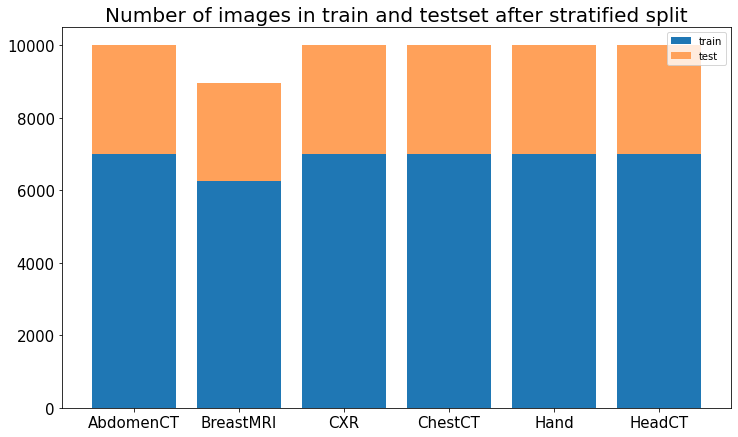

In [20]:
plt.figure(figsize=(12,7))
plt.bar(labels, labels_cnt_train, label='train', color='#1F77B4')
plt.bar(labels, labels_cnt_test, bottom=labels_cnt_train, label='test', color='#FFA15A')
plt.title('Number of images in train and testset after stratified split', fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Without *stratify*:

In [21]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X, y, test_size=0.3, random_state=1)

In [22]:
labels_cnt_train_v2 = []
labels_cnt_test_v2 = []

for label in labels:
  labels_cnt_train_v2.append(np.count_nonzero(y_train_v2 == label))
  labels_cnt_test_v2.append(np.count_nonzero(y_test_v2 == label))

In [23]:
labels_cnt_train_v2, labels_cnt_test_v2

([7080, 6292, 6853, 6996, 6992, 7054], [2920, 2662, 3147, 3004, 3008, 2946])

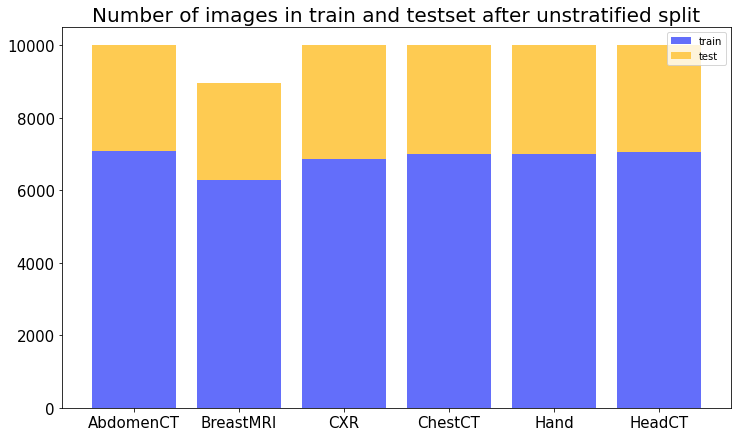

In [24]:
plt.figure(figsize=(12,7))
plt.bar(labels, labels_cnt_train_v2, label='train', color='#636EFA')
plt.bar(labels, labels_cnt_test_v2, bottom=labels_cnt_train_v2, label='test', color='#FECB52')
plt.title('Number of images in train and testset after unstratified split', fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

Compare both split types:

In [25]:
fig = go.Figure(
    data = [
      go.Bar(name="X_train", x=labels, y=labels_cnt_train, offsetgroup=0, marker_color='#1F77B4'),
      go.Bar(name="X_test", x=labels, y=labels_cnt_test, offsetgroup=0, base=labels_cnt_train, marker_color='#FFA15A'),
      go.Bar(name="X_train without stratify", x=labels, y=labels_cnt_train_v2, offsetgroup=1, marker_color='#636EFA'),
      go.Bar(name="X_test without stratify", x=labels, y=labels_cnt_test_v2, offsetgroup=1, base=labels_cnt_train_v2, marker_color='#FECB52')],

    layout=go.Layout(
      title='Comparison of train and testset sizes after stratified and unstritified split',
      yaxis_title='Set size', height=700, font=dict(size=15))
)

fig.add_shape(type='line', x0=-1, y0=7000, x1=6, y1=7000, line=dict(width=1, dash='dot'))

fig.show()

## Data augmentation

In [26]:
def data_augmentation(X_train, y_train, hflip=False, crop=False, rotate=False):
  sub = 1
  if (hflip or crop or rotate):
    plt.figure(figsize=(20,4))
    plt.suptitle('Examples of augmented images', fontsize=20)

  if hflip:
    X_hflip = X_train[:,:,::-1]
    X_train = np.vstack((X_train, X_hflip))
    y_train = np.hstack((y_train, y_train))

    plt.subplot(1,6,sub)
    plt.imshow(X_train[40000], cmap='gray')
    plt.title('Original - {}'.format(y_train[40000]))
    plt.subplot(1,6,sub+1)
    plt.imshow(X_hflip[40000], cmap='gray')
    plt.title('Horizontal flip - {}'.format(y_train[40000]))
    sub = sub + 2


  if crop:
    X_crop = []
    transform = A.RandomSizedCrop((size-size//2, size-size//5), size, size, p=1)
  
    for i in range(X_train.shape[0]):
      aug_img = transform(image=X_train[i])['image']
      X_crop.append(aug_img)

    X_crop = np.asarray(X_crop)
    X_train = np.vstack((X_train, X_crop))
    y_train = np.hstack((y_train, y_train))

    plt.subplot(1,6,sub)
    plt.imshow(X_train[40000], cmap='gray')
    plt.title('Original - {}'.format(y_train[40000]))
    plt.subplot(1,6,sub+1)
    plt.imshow(X_crop[40000], cmap='gray')
    plt.title('Crop - {}'.format(y_train[40000]))
    sub = sub + 2


  if rotate:
    X_rotate=[]
    transform = A.Rotate(180, p=1)

    for i in range(X_train.shape[0]):
      aug_img = transform(image=X_train[i])['image']
      X_rotate.append(aug_img)

    X_rotate = np.asarray(X_rotate)
    X_train = np.vstack((X_train, X_rotate))
    y_train = np.hstack((y_train, y_train))

    plt.subplot(1,6,sub)
    plt.imshow(X_train[40000], cmap='gray')
    plt.title('Original - {}'.format(y_train[40000]))
    plt.subplot(1,6,sub+1)
    plt.imshow(X_rotate[40000], cmap='gray')
    plt.title('Rotation - {}'.format(y_train[40000]))


  return X_train, y_train

In [27]:
X_train, y_train = data_augmentation(X_train, y_train)
X_train.shape, y_train.shape

((41267, 64, 64), (41267,))

## Prepare sets for model

Pixels has values 0-255, 115-255 or 50-255:

In [28]:
for label in labels:
  print(label, ' ', np.min(X[y==label]), '-', np.max(X[y == label]))

AbdomenCT   50 - 255
BreastMRI   0 - 255
CXR   0 - 255
ChestCT   115 - 255
Hand   0 - 255
HeadCT   0 - 255


In [29]:
def preprocess(X_train, y_train, X_test, y_test):
  '''Normalization, add channel, convert labels into numbers, one-hot encode y'''
  
  if np.max(X_train) > 1: X_train = X_train / np.max(X_train)
  if np.max(X_test) > 1: X_test = X_test / np.max(X_test)

  if X_train.ndim == 3: X_train = np.expand_dims(X_train, axis=-1)
  if X_test.ndim == 3 : X_test = np.expand_dims(X_test, axis=-1)

  if y_train.dtype.type is np.str_:
    y_train = list(map(lambda x: labels.index(x), y_train))
    y_train = np.asarray(y_train)
    y_test = list(map(lambda x: labels.index(x), y_test))
    y_test = np.asarray(y_test)

  if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

  return X_train, y_train, X_test, y_test

In [30]:
X_train, y_train, X_test, y_test = preprocess(X_train, y_train, X_test, y_test)

In [31]:
print('Maximum pixel values: ', np.max(X_train), np.max(X_test))
print('X shape: ', X_train.shape, X_test.shape)
print('y shape: ', y_train.shape, y_test.shape)

Maximum pixel values:  1.0 1.0
X shape:  (41267, 64, 64, 1) (17687, 64, 64, 1)
y shape:  (41267, 6) (17687, 6)


In [32]:
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

In [33]:
np.save('X_train_' + str(size), X_train)
np.save('X_test_' + str(size), X_test)
np.save('y_train_' + str(size), y_train)
np.save('y_test_' + str(size), y_test)

Images generator - randomly selects resolution from 24 x 24 to 64 x 64 px:

In [34]:
def generate_images_various_sizes(X_train, y_train, batch_size):
  bx = []
  by = []
  batch_count = 0
  size = random.randrange(24, 64)

  while True:
    for i in range(X_train.shape[0]):
      transform = A.Resize(size, size, p=1)
      x = transform(image=X_train[i])['image']
      y = y_train[i]

      batch_count += 1

      bx.append(x)
      by.append(y)

      if batch_count > batch_size:
        bx = np.asarray(bx, dtype=np.float32)
        by = np.asarray(by, dtype=np.float32)

        yield (bx, by)

        bx = []
        by = []
        batch_count = 0
        size = random.randrange(24, 64)

## Model

In [35]:
def get_model():
  model = Sequential([
          Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
          MaxPooling2D((2,2)),
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D((2,2)),
          Conv2D(64, (3,3), activation='relu'),
          Flatten(),
          Dense(64, activation='relu'),
          Dense(num_classes, activation='softmax')
  ])

  return model

In [36]:
model_name = 'baseline'

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [37]:
def train_model(maxit, X, y, batch_size=32, epochs=30, verbose=0, steps_per_epoch=None):
  errors_cnt = []
  history_acc = []
  history_val_acc = []
  history_loss = []
  history_val_loss = []

  for _ in range(maxit):
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)
    
    model = get_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, steps_per_epoch=steps_per_epoch, batch_size=batch_size)

    y_pred = model.predict(X_test)

    errors = np.count_nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))
    errors_cnt.append(errors)

    print('Iteration: ', _ + 1, 'Mistakes: ', errors)

    history_acc.append(history.history['accuracy'])
    history_val_acc.append(history.history['val_accuracy'])
    history_loss.append(history.history['loss'])
    history_val_loss.append(history.history['val_loss'])

    if _ + 1 < maxit:
      del model, y_pred, errors, history
      gc.collect()

    else:
      tf.io.gfile.makedirs('results/' + model_name)
      np.save('/content/results/' + model_name + '/errors', errors_cnt)
      np.save('/content/results/' + model_name + '/accuracy', history_acc)
      np.save('/content/results/' + model_name + '/val_accuracy', history_val_acc)
      np.save('/content/results/' + model_name + '/loss', history_loss)
      np.save('/content/results/' + model_name + '/val_loss', history_val_loss)

      return model, y_pred, errors, history

In [38]:
model, y_pred, errors, history = train_model(1, X=X_train, y=y_train, verbose=1)

Epoch 1/30
1290/1290 [==============================] - 16s 7ms/step - loss: 0.1655 - accuracy: 0.9473 - val_loss: 0.0066 - val_accuracy: 0.9985
Epoch 2/30
1290/1290 [==============================] - 8s 6ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0149 - val_accuracy: 0.9958
Epoch 3/30
1290/1290 [==============================] - 8s 6ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0095 - val_accuracy: 0.9980
Epoch 4/30
1290/1290 [==============================] - 8s 6ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0039 - val_accuracy: 0.9986
Epoch 5/30
1290/1290 [==============================] - 8s 7ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0052 - val_accuracy: 0.9988
Epoch 6/30
1290/1290 [==============================] - 8s 7ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0086 - val_accuracy: 0.9982
Epoch 7/30
1290/1290 [==============================] - 8s 7ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy

In [39]:
model.save('models/' + model_name)

INFO:tensorflow:Assets written to: models/baseline/assets


Train with image generator (different images sizes):

In [40]:
batch_size = 32

train_model(100, X=generate_images_various_sizes(X_train, y_train, batch_size), y=None, steps_per_epoch=X_train.shape[0]/batch_size)

## Results

Accuracy and loss:

In [41]:
def plot_acc_loss(history):
  plt.figure(figsize=(20,6))

  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(loc=4)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.legend()
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15);

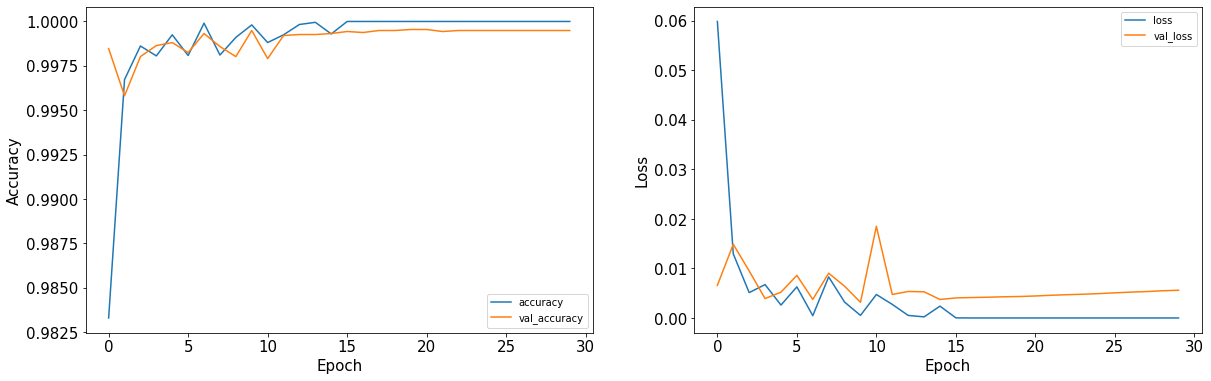

In [42]:
plot_acc_loss(history)

Confusion matrix:

In [43]:
def get_classes(y_test, y_pred):
  y_test_classes = []
  y_pred_classes = []

  for i, val in enumerate(y_test):
    y_test_classes.append(np.argmax(val))

  for i, val in enumerate(y_pred):
    y_pred_classes.append(np.argmax(val))

  return y_test_classes, y_pred_classes


def show_confusion_matrix():
  y_test_classes, y_pred_classes = get_classes(y_test, y_pred)
  cm = confusion_matrix(y_test_classes, y_pred_classes)
  plt.figure(figsize=(11, 10))
  sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, annot_kws={'size':15}, cbar=False)
  plt.xlabel('Predicted values', fontsize=15)
  plt.ylabel('True values', fontsize=15)
  plt.xticks(fontsize=15, rotation=0)
  plt.yticks(fontsize=15, va='center');

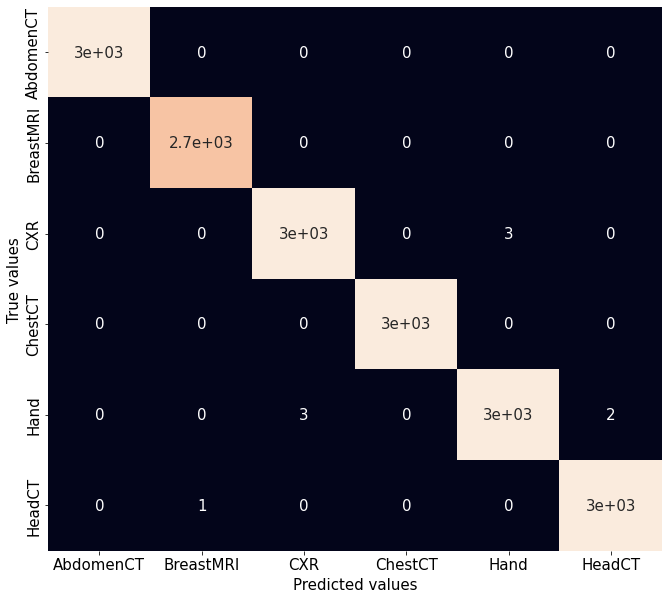

In [44]:
show_confusion_matrix()

Visualise model's mistakes:

In [45]:
def wrong_pred(y_test, y_pred):
  for idx, (a, b) in enumerate(zip(y_test, y_pred)):
    if np.argmax(a) == np.argmax(b): continue

    yield idx, np.argmax(a), np.argmax(b)


def show_mistakes():
  X_test_plot = X_test.reshape( X_test.shape[:-1] )

  plt.figure(figsize=(20,15))
  for i, (idx, y_test_val, y_pred_val) in enumerate(wrong_pred(y_test, y_pred)):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test_plot[idx], cmap='gray')
    plt.title('True: {}\nPred: {}'.format(labels[y_test_val], labels[y_pred_val]), fontsize=15)

  plt.tight_layout() 
  plt.show();

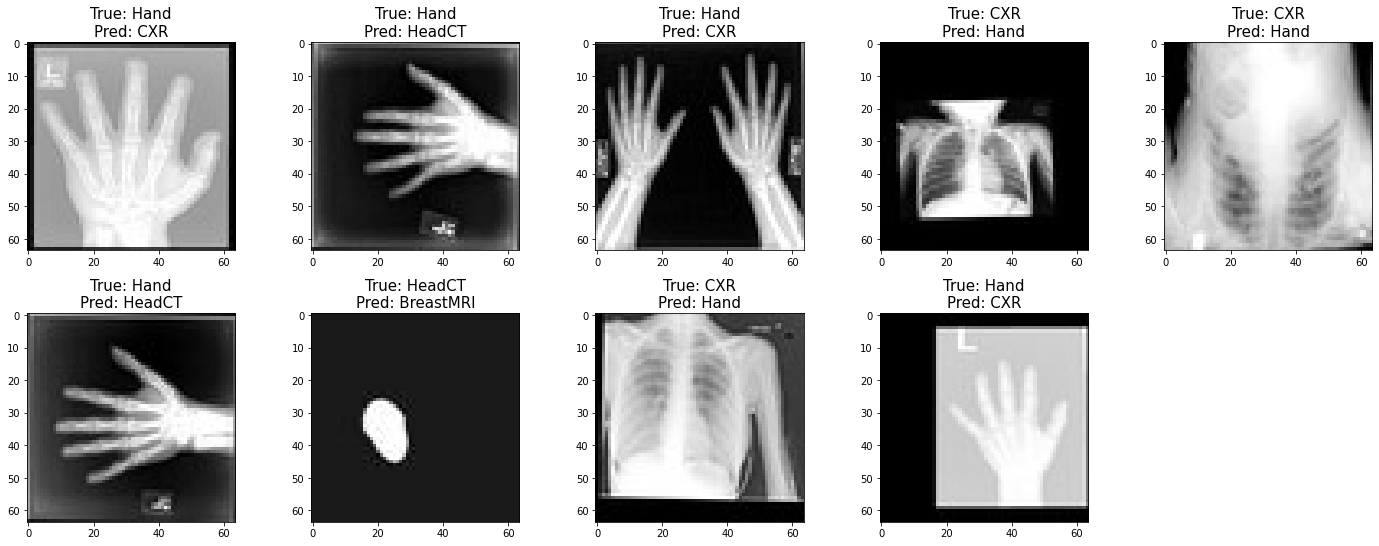

In [46]:
show_mistakes()

## Reproducibility of results

In [47]:
with tf.device("/cpu:0"):
  print('CPU')
  errors_cnt_cpu = train_model(5, X=X_train[::5], y=y_train[::5], epochs=1, verbose=1)

CPU
258/258 [==============================] - 55s 210ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.0365 - val_accuracy: 0.9928
Iteration:  1 Mistakes:  128
258/258 [==============================] - 55s 212ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.0365 - val_accuracy: 0.9928
Iteration:  2 Mistakes:  128
258/258 [==============================] - 56s 214ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.0365 - val_accuracy: 0.9928
Iteration:  3 Mistakes:  128
258/258 [==============================] - 57s 218ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.0365 - val_accuracy: 0.9928
Iteration:  4 Mistakes:  128
258/258 [==============================] - 56s 215ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.0365 - val_accuracy: 0.9928
Iteration:  5 Mistakes:  128


In [48]:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print('GPU')
    errors_cnt_gpu = train_model(5, X=X_train[::5], y=y_train[::5], epochs=1, verbose=1)

else:
  print("GPU: not found")

GPU
258/258 [==============================] - 4s 13ms/step - loss: 0.4117 - accuracy: 0.8410 - val_loss: 0.0569 - val_accuracy: 0.9861
Iteration:  1 Mistakes:  246
258/258 [==============================] - 4s 13ms/step - loss: 0.4098 - accuracy: 0.8418 - val_loss: 0.0780 - val_accuracy: 0.9821
Iteration:  2 Mistakes:  316
258/258 [==============================] - 4s 13ms/step - loss: 0.4103 - accuracy: 0.8414 - val_loss: 0.0456 - val_accuracy: 0.9885
Iteration:  3 Mistakes:  204
258/258 [==============================] - 4s 13ms/step - loss: 0.4099 - accuracy: 0.8415 - val_loss: 0.0469 - val_accuracy: 0.9894
Iteration:  4 Mistakes:  187
258/258 [==============================] - 4s 13ms/step - loss: 0.4098 - accuracy: 0.8406 - val_loss: 0.0728 - val_accuracy: 0.9781
Iteration:  5 Mistakes:  388
